In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
%matplotlib inline
warnings.filterwarnings('ignore')
data = pd.read_csv('2015_Air_quality_in_northern_Taiwan.csv')

In [2]:
# We want to predict PM2.5, so we delete the rows with NA in 'PM2.5'
data = data[data['PM2.5'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215768 entries, 0 to 218639
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        215768 non-null  object
 1   station     215768 non-null  object
 2   AMB_TEMP    198538 non-null  object
 3   CH4         95104 non-null   object
 4   CO          215577 non-null  object
 5   NMHC        94927 non-null   object
 6   NO          215509 non-null  object
 7   NO2         215102 non-null  object
 8   NOx         215510 non-null  object
 9   O3          198280 non-null  object
 10  PH_RAIN     34202 non-null   object
 11  PM10        215561 non-null  object
 12  PM2.5       215768 non-null  object
 13  RAINFALL    207268 non-null  object
 14  RAIN_COND   34202 non-null   object
 15  RH          198612 non-null  object
 16  SO2         215326 non-null  object
 17  THC         95105 non-null   object
 18  UVB         25755 non-null   object
 19  WD_HR       181237 non-null 

In [3]:
(data.isna().sum() / len(data)).sort_values(ascending=False)

UVB           0.880636
RAIN_COND     0.841487
PH_RAIN       0.841487
NMHC          0.560051
CH4           0.559230
THC           0.559226
WS_HR         0.162068
WIND_DIREC    0.161257
WIND_SPEED    0.161122
WD_HR         0.160038
O3            0.081050
AMB_TEMP      0.079854
RH            0.079511
RAINFALL      0.039394
NO2           0.003087
SO2           0.002048
NO            0.001200
NOx           0.001196
PM10          0.000959
CO            0.000885
PM2.5         0.000000
station       0.000000
time          0.000000
dtype: float64

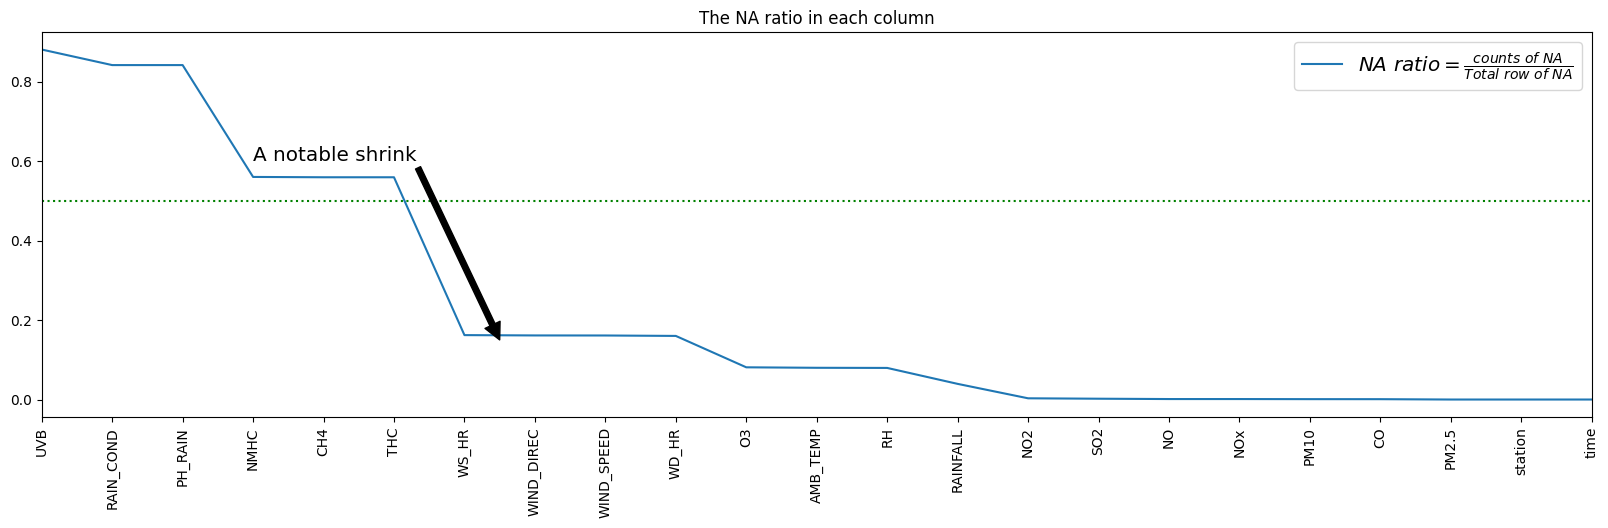

In [4]:
plt.figure(figsize=(20,5))
plt.title('The NA ratio in each column')
plt.xticks(rotation='vertical')
plt.plot([0,22],[0.5,0.5],'g:')
plt.plot((data.isna().sum() / len(data)).sort_values(ascending=False).index,
         (data.isna().sum() / len(data)).sort_values(ascending=False).values,'-',label=r'$NA \ ratio = \frac{counts \ of \ NA}{Total \ row \ of \ NA}$')
plt.annotate('A notable shrink', xy=(6.5, 0.15), xytext=(3, 0.6),fontsize='x-large',
            arrowprops={'facecolor':'black','shrink':1.0}
            )
plt.xlim(0,22)
_ = plt.legend(fontsize='x-large')

In [5]:
data['UVB'].value_counts()

UVB
0       13513
0.1      1079
0.2       594
0.3       540
0.4       462
        ...  
5.3#        1
3.9#        1
0.2#        1
0.6#        1
0.3         1
Name: count, Length: 150, dtype: int64

In [6]:
data.drop(['UVB','RAIN_COND','PH_RAIN'],axis=1,inplace=True)

In [7]:
data[data['CO'].isna()].head()

,time,station,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
466,2015/01/20 10:00,Banqiao,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,40,NR,55,NaN,NaN,67,68,4,3
4978,2015/07/27 10:00,Banqiao,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,16,NR,53,NaN,NaN,236,232,2.6,2.6
4979,2015/07/27 11:00,Banqiao,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,16,NR,51,NaN,NaN,243,218,2.4,2.5
4981,2015/07/27 13:00,Banqiao,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,15,NR,51,NaN,NaN,262#,0#,0#,2.5#
7358,2015/11/03 14:00,Banqiao,23,1.5#,NaN,0.17#,5.1#,27#,32#,21,40,10,NR,83,3.4,1.6#,78,62,2.3,2


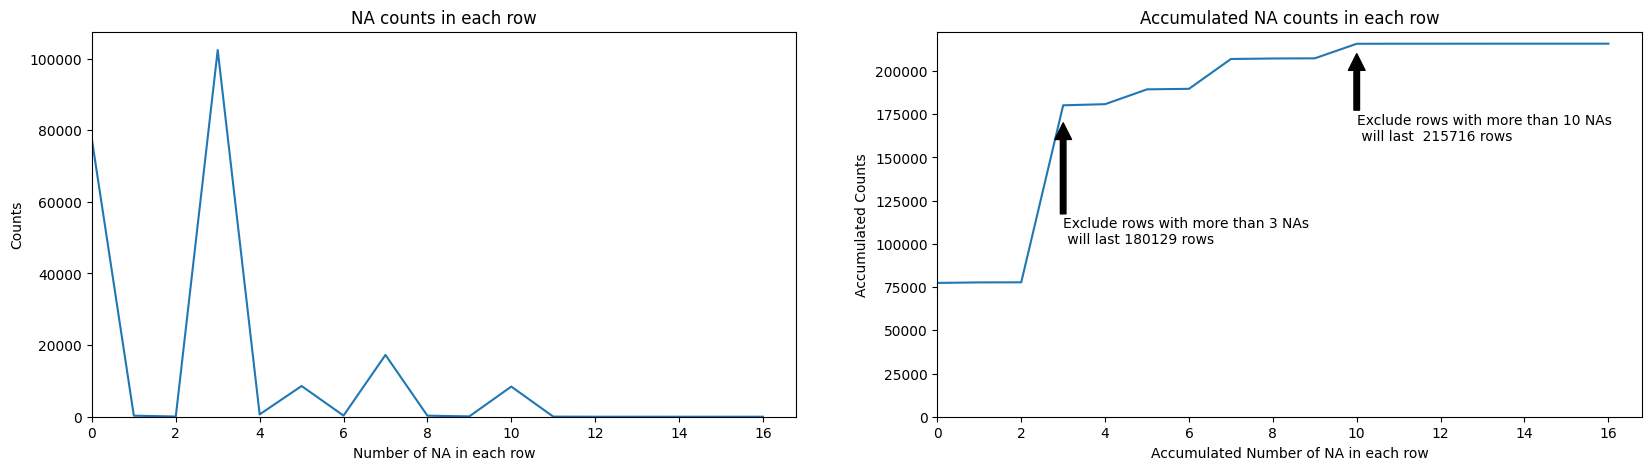

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('NA counts in each row')
plt.plot(data.isna().sum(axis=1).value_counts().sort_index())
plt.xlabel('Number of NA in each row')
plt.ylabel('Counts')
plt.xlim(0)
plt.ylim(0)

plt.subplot(1,2,2)
plt.title('Accumulated NA counts in each row')
plt.plot(data.isna().sum(axis=1).value_counts().sort_index().cumsum())
plt.annotate('Exclude rows with more than 10 NAs \n will last  215716 rows', xy=(10, 210000), xytext=(10, 160000),fontsize='medium',
            arrowprops={'facecolor':'black','shrink':1.0})
plt.annotate('Exclude rows with more than 3 NAs \n will last 180129 rows', xy=(3, 170000), xytext=(3, 100000),fontsize='medium',
            arrowprops={'facecolor':'black','shrink':1.0})
plt.xlabel('Accumulated Number of NA in each row')
plt.ylabel('Accumulated Counts')
plt.xlim(0)
_= plt.ylim(0)

In [9]:
data = data.dropna(thresh=17) # 17 = len(data.columns) - 3

In [10]:
def numeric(row):
    try:
        if np.isnan(row):
            return
        else:
            row =str(row)
            return float(row.replace('x','').replace('#','').replace('*',''))
    except TypeError:
        row =str(row)
        return float(row.replace('x','').replace('#','').replace('*',''))

In [11]:
data['WS_HR'] = data['WS_HR'].apply(numeric)
print(data['WS_HR'].describe())
print('\nThe skewness:',data['WS_HR'].skew())
print('Right skewed') if data['WS_HR'].skew()>0 else print('Left skewed')

count    180128.000000
mean          1.987993
std           1.726888
min           0.000000
25%           0.800000
50%           1.500000
75%           2.700000
max          50.000000
Name: WS_HR, dtype: float64

The skewness: 4.005978883220031
Right skewed


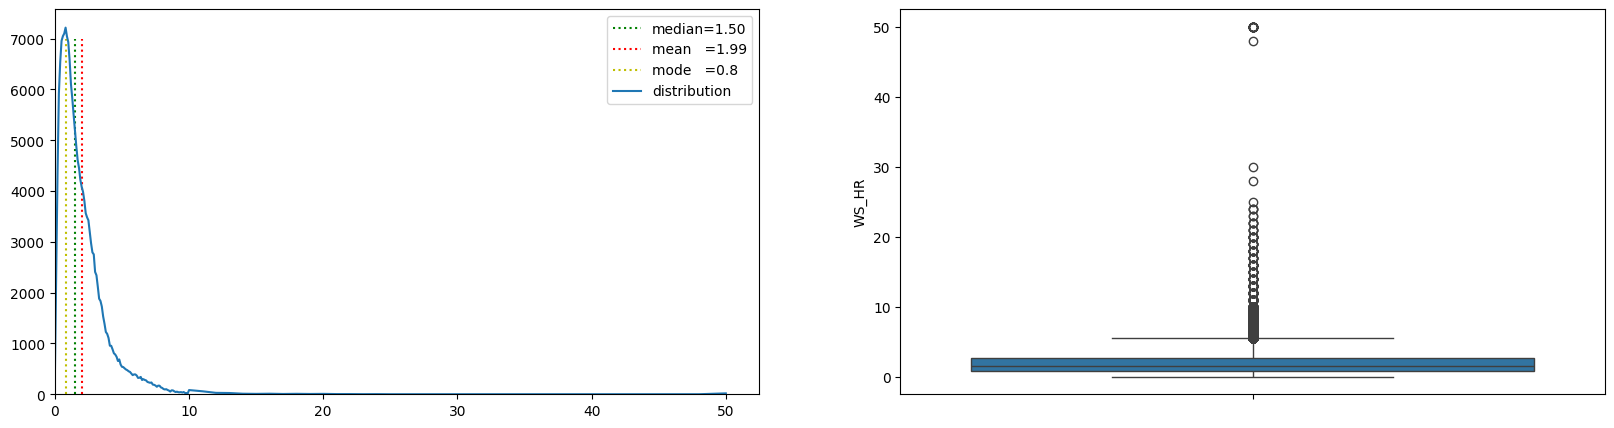

In [12]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot([data['WS_HR'].median(),data['WS_HR'].median()],[0,7000],'g:',label='median={0:.2f}'.format(data['WS_HR'].median()))
plt.plot([data['WS_HR'].mean(),data['WS_HR'].mean()],[0,7000],'r:',label='mean   ={0:.2f}'.format(data['WS_HR'].mean()))
plt.plot([data['WS_HR'].mode(),data['WS_HR'].mode()],[0,7000],'y:',label='mode   ={}'.format(data['WS_HR'].mode()[0]))
plt.plot(data['WS_HR'].value_counts().sort_index(),label='distribution')
plt.legend(loc='upper right')
plt.xlim(0)
plt.ylim(0)
plt.subplot(1,2,2)
_=sns.boxplot(data['WS_HR'])

In [13]:
data['WS_HR'].fillna(value=data['WS_HR'].median(),inplace=True)

In [14]:
for col in ['NO2','NO','NOx','PM10','CO','O3','AMB_TEMP','SO2','WD_HR','RH','WIND_DIREC', 'WIND_SPEED','PM2.5']:
    data[col]=data[col].apply(numeric)
    data[col].fillna(value=data[col].median(),inplace=True)
data['RAINFALL'] = data['RAINFALL'].apply(lambda x:0 if x=='NR' else x).apply(numeric)

In [15]:
print((data['CH4'].notna() & data['NMHC'].notna() & data['THC'].isna()).value_counts())
print('\n')
print(data['THC'].apply(numeric).describe())
print('\nMode :',data['THC'].apply(numeric).mode())
print('\nKurtosis is ',data['THC'].apply(numeric).kurt(),'>3, it is leptokurtic')

False    180129
Name: count, dtype: int64


count    77803.000000
mean         2.121760
std          0.341647
min         -0.300000
25%          1.900000
50%          2.100000
75%          2.200000
max         20.000000
Name: THC, dtype: float64

Mode : 0    2.0
Name: THC, dtype: float64

Kurtosis is  109.04199317121108 >3, it is leptokurtic


<Axes: ylabel='count'>

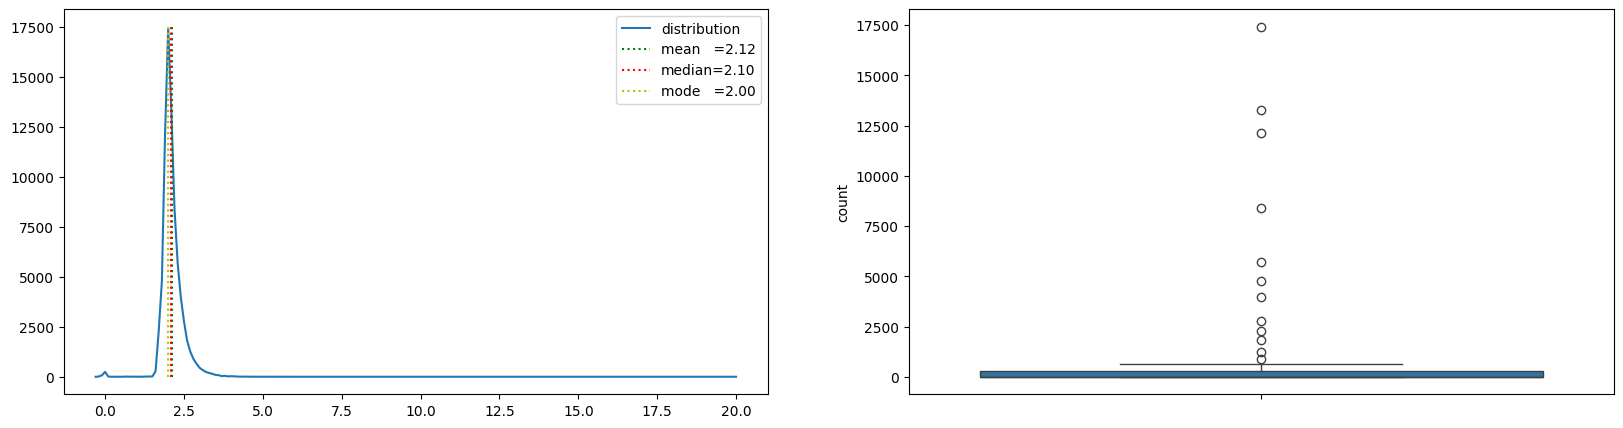

In [16]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(data['THC'].apply(numeric).value_counts().sort_index(),label='distribution')
plt.plot([data['THC'].apply(numeric).mean()]*2,[0,17500],'g:',label='mean   ={0:.2f}'.format(data['THC'].apply(numeric).mean()))
plt.plot([data['THC'].apply(numeric).median()]*2,[0,17500],'r:',label='median={0:.2f}'.format(data['THC'].apply(numeric).median()))
plt.plot([data['THC'].apply(numeric).mode()[0]]*2,[0,17500],'y:',label='mode   ={0:.2f}'.format(data['THC'].apply(numeric).mode()[0]))
plt.legend()

plt.subplot(1,2,2)
sns.boxplot(data['THC'].apply(numeric).value_counts().sort_index())

In [17]:
data.drop(['CH4','NMHC','THC'],axis=1,inplace=True)

In [18]:
data['year'] = pd.to_datetime(data['time']).dt.year
data['month'] = pd.to_datetime(data['time']).dt.month
data['day'] = pd.to_datetime(data['time']).dt.day
data['hour'] = pd.to_datetime(data['time']).dt.hour
# data.drop('time',axis=1,inplace=True)

In [19]:
continous_columns=['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5', 'RAINFALL','RH', 'SO2', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'WS_HR']
discrete_columns=['station','year','month','day','hour']

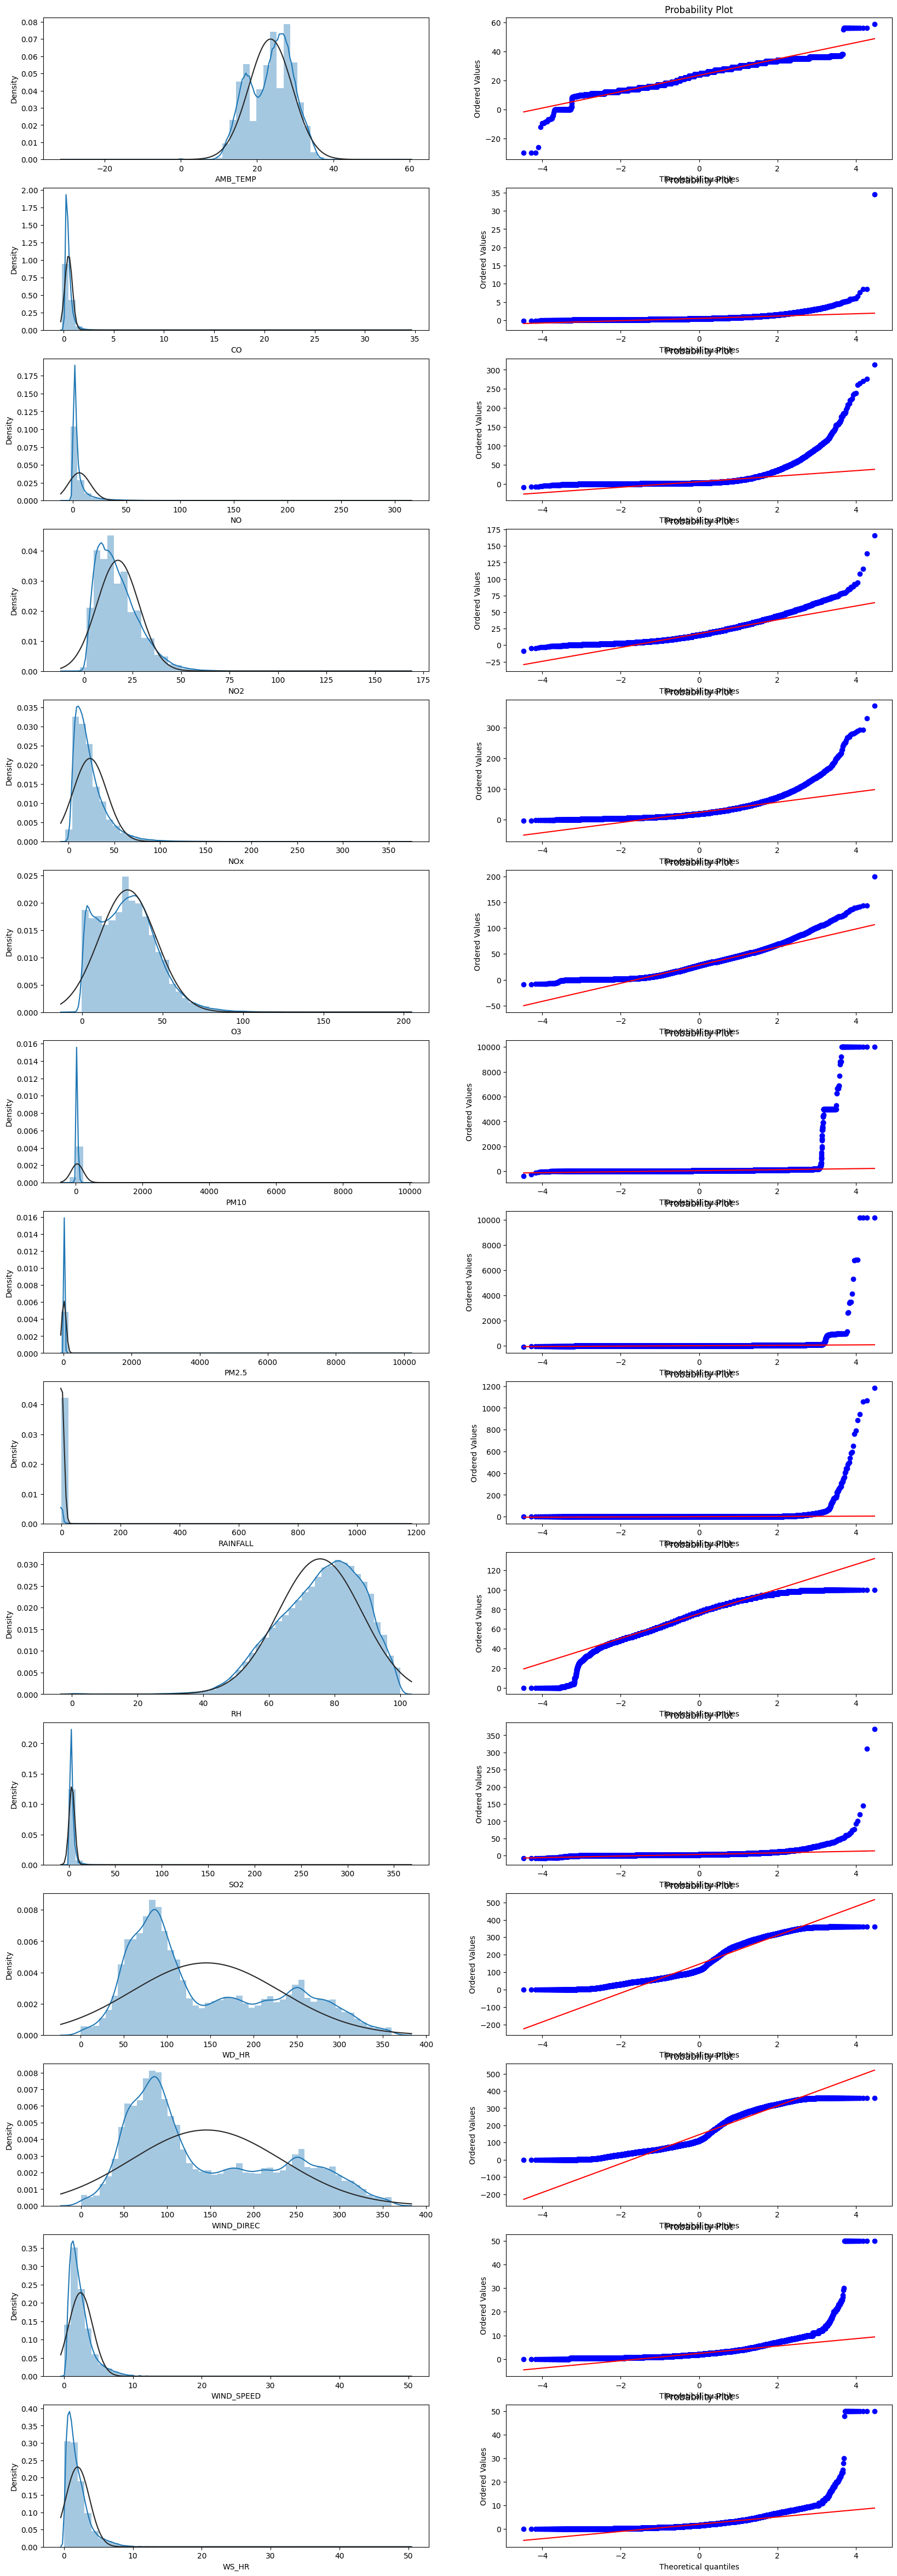

In [20]:
plt.figure(figsize=(20,60))
for number,col in enumerate(continous_columns):
    plt.subplot(15,2,number*2+1)
    sns.distplot(data[col],fit=norm)
    plt.subplot(15,2,number*2+2)
    res = stats.probplot(data[col],plot=plt)

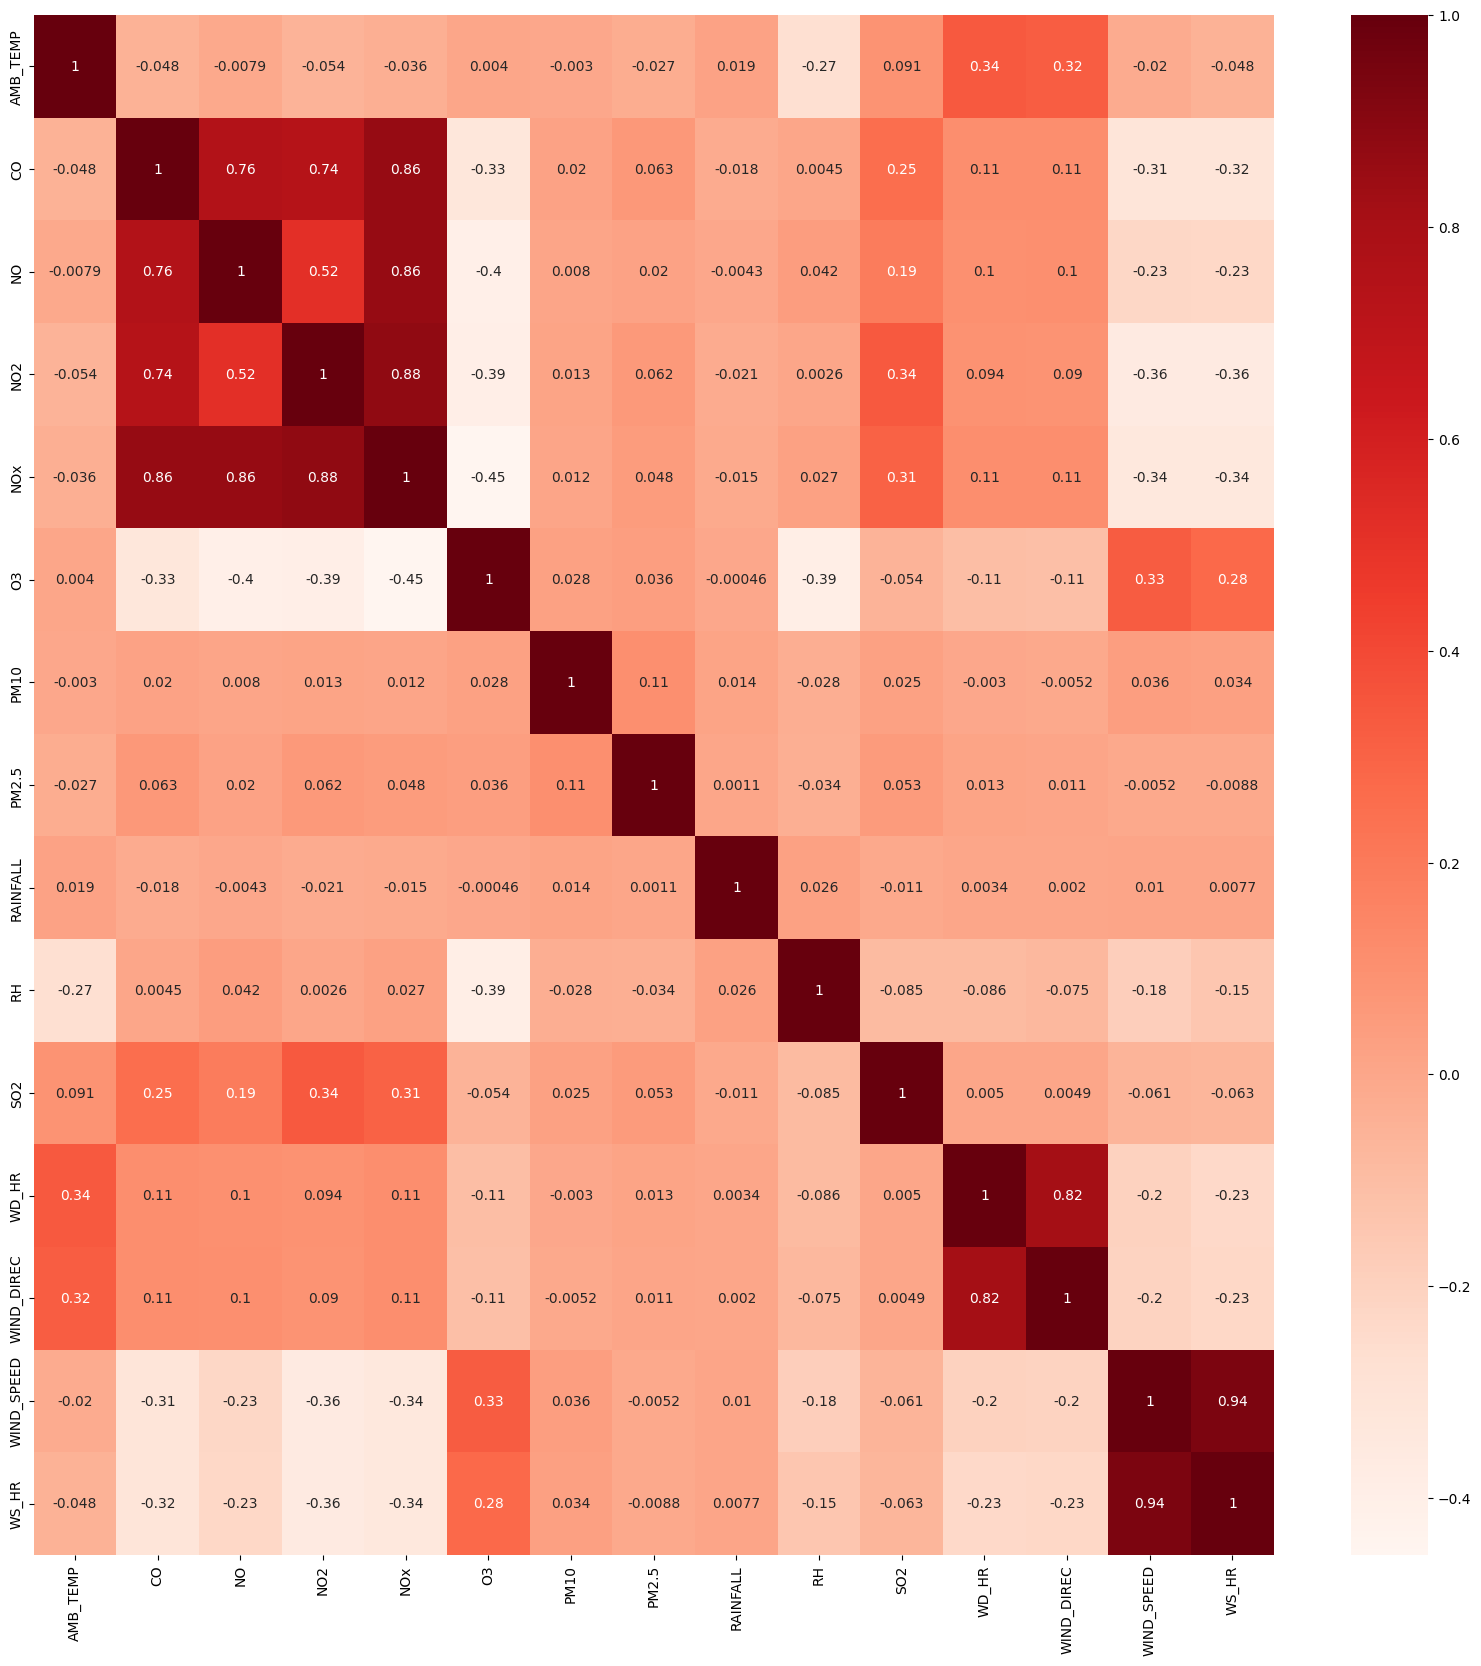

In [22]:
plt.figure(figsize=(20,20))
hm=sns.heatmap(data[continous_columns].corr().values,annot=True,
               xticklabels=continous_columns,
               yticklabels=continous_columns,
               cmap='Reds')

In [23]:
abs(data[continous_columns].corr()['PM2.5']).sort_values(ascending=False) # absolute number

PM2.5         1.000000
PM10          0.105216
CO            0.063448
NO2           0.062013
SO2           0.052850
NOx           0.047903
O3            0.035956
RH            0.034052
AMB_TEMP      0.026617
NO            0.020369
WD_HR         0.013212
WIND_DIREC    0.011287
WS_HR         0.008805
WIND_SPEED    0.005211
RAINFALL      0.001075
Name: PM2.5, dtype: float64

In [24]:
#we are taking Banqiao station for model building example.
data_Banqiao = data[data['station']=='Banqiao'].sort_values(by=['year','month','day','hour'])

In [25]:
for col in ['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10','RAINFALL', 'RH', 'SO2', 'WD_HR']:
    stdscl = StandardScaler()
    data_Banqiao[col] = stdscl.fit_transform(data_Banqiao[col].values.reshape(-1,1))

In [26]:
data_Banqiao

,time,station,AMB_TEMP,CO,NO,NO2,NOx,O3,PM10,PM2.5,...,RH,SO2,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,year,month,day,hour
0,2015/01/01 00:00,Banqiao,-1.418977,0.643614,-0.560008,-0.570777,-0.665605,0.547542,1.659443,78.0,...,-1.170028,3.311547,-0.831355,69.0,4.7,4.2,2015,1,1,0
1,2015/01/01 01:00,Banqiao,-1.418977,0.674154,-0.548496,-0.570777,-0.665605,0.495904,1.672057,77.0,...,-1.170028,2.913075,-0.853002,65.0,4.0,4.0,2015,1,1,1
2,2015/01/01 02:00,Banqiao,-1.418977,0.399292,-0.583032,-0.859664,-0.848577,0.599180,1.482843,72.0,...,-1.170028,1.717658,-0.896297,53.0,3.7,3.5,2015,1,1,2
3,2015/01/01 03:00,Banqiao,-1.593872,0.246591,-0.606055,-1.052256,-0.970558,0.650818,1.281014,65.0,...,-1.086182,1.119950,-0.896297,63.0,4.1,3.3,2015,1,1,3
4,2015/01/01 04:00,Banqiao,-1.593872,-0.150432,-0.629079,-1.148552,-1.031549,0.599180,1.079185,56.0,...,-1.086182,0.721478,-0.831355,67.0,3.0,3.1,2015,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2015/12/31 19:00,Banqiao,-1.244083,1.407119,-0.237676,1.451436,0.798170,0.392629,0.978271,67.0,...,-0.834645,1.319186,-0.647353,87.0,1.6,2.1,2015,12,31,19
8756,2015/12/31 20:00,Banqiao,-1.244083,0.887936,-0.341283,0.777365,0.310245,0.702456,0.940428,70.0,...,-0.750799,1.119950,-0.669000,82.0,2.0,1.7,2015,12,31,20
8757,2015/12/31 21:00,Banqiao,-1.244083,0.643614,-0.375819,0.295886,0.005292,0.650818,0.953042,70.0,...,-0.499261,0.203464,-0.647353,86.0,2.3,1.6,2015,12,31,21
8758,2015/12/31 22:00,Banqiao,-1.244083,0.643614,-0.364307,0.295886,0.005292,0.392629,0.864742,67.0,...,-0.415415,-0.155161,-0.669000,67.0,1.6,1.0,2015,12,31,22


In [27]:
import pandas as pd

# Assuming data_Banqiao is your DataFrame

# Drop rows with missing values
data_Banqiao.dropna(inplace=True)

# Shift the 'PM2.5' column to create the 'next_hour_pm2.5' column
data_Banqiao['next_hour_pm2.5'] = data_Banqiao['PM2.5'].shift(-1)

# Drop the last row (since shifting introduces NaN in the last row)
data_Banqiao.drop(data_Banqiao.index[-1], inplace=True)

# Split the data into training and testing sets based on the 'month' column
train_data = data_Banqiao[data_Banqiao['month'] != 12]
test_data = data_Banqiao[data_Banqiao['month'] == 12]

# Extract features and target for training set
y_train = train_data['next_hour_pm2.5'].values
x_train = train_data.loc[:, 'AMB_TEMP':'hour'].values

# Extract features and target for testing set
y_test = test_data['next_hour_pm2.5'].values
x_test = test_data.loc[:, 'AMB_TEMP':'hour'].values
x_train

array([[-1.41897748,  0.64361376, -0.56000809, ...,  1.        ,
         1.        ,  0.        ],
       [-1.41897748,  0.67415398, -0.54849624, ...,  1.        ,
         1.        ,  1.        ],
       [-1.41897748,  0.399292  , -0.58303178, ...,  1.        ,
         1.        ,  2.        ],
       ...,
       [-0.54450558, -0.18097217, -0.43337777, ..., 11.        ,
        30.        , 21.        ],
       [-0.54450558, -0.24205261, -0.50244885, ..., 11.        ,
        30.        , 22.        ],
       [-0.54450558, -0.63907547, -0.56000809, ..., 11.        ,
        30.        , 23.        ]])

In [28]:
# Need to check if it's suitable, because it will interrupt the continuity of time, e.g. is it proper to use time T+1 and Time T-1 to predirct Time T? Maybe not, but grid search is doing so. Therefore, I think maybe it's not fair to compare this RF to LSTM.
g_search = GridSearchCV(RandomForestRegressor(n_jobs=-1),param_grid={'n_estimators':[5,10,20],'max_features':[5,10],'max_depth':[10,20,30]},scoring='neg_mean_squared_error',n_jobs=-1,cv=2)
g_search.fit(x_train,y_train)
y_rf_pred = g_search.best_estimator_.predict(x_test)
pd.DataFrame(g_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.127782,0.003999,0.039446,0.013763,10,5,5,"{'max_depth': 10, 'max_features': 5, 'n_estima...",-386.328393,-258.297389,-322.312891,64.015502,18
1,0.168024,0.023644,0.075505,0.004422,10,5,10,"{'max_depth': 10, 'max_features': 5, 'n_estima...",-377.966293,-58.226603,-218.096448,159.869845,8
2,0.385807,0.053071,0.333093,0.018082,10,5,20,"{'max_depth': 10, 'max_features': 5, 'n_estima...",-382.327243,-48.628068,-215.477656,166.849588,6
3,0.230887,0.011587,0.239401,0.070982,10,10,5,"{'max_depth': 10, 'max_features': 10, 'n_estim...",-377.266836,-160.846268,-269.056552,108.210284,15
4,0.443377,0.073708,0.157978,0.075682,10,10,10,"{'max_depth': 10, 'max_features': 10, 'n_estim...",-372.843702,-96.000562,-234.422132,138.421570,13
5,0.570989,0.005791,0.140336,0.070549,10,10,20,"{'max_depth': 10, 'max_features': 10, 'n_estim...",-372.304315,-40.138782,-206.221548,166.082767,4
6,0.271934,0.106024,0.241981,0.012794,20,5,5,"{'max_depth': 20, 'max_features': 5, 'n_estima...",-389.141282,-66.077983,-227.609633,161.531650,11
7,0.311613,0.006060,0.176964,0.114615,20,5,10,"{'max_depth': 20, 'max_features': 5, 'n_estima...",-388.101634,-47.351288,-217.726461,170.375173,7
8,0.579010,0.139844,0.422425,0.129617,20,5,20,"{'max_depth': 20, 'max_features': 5, 'n_estima...",-378.850950,-64.538799,-221.694875,157.156075,10
9,0.434514,0.050384,0.148165,0.015230,20,10,5,"{'max_depth': 20, 'max_features': 10, 'n_estim...",-383.073229,-185.692821,-284.383025,98.690204,16


MSE 238.6355522890598


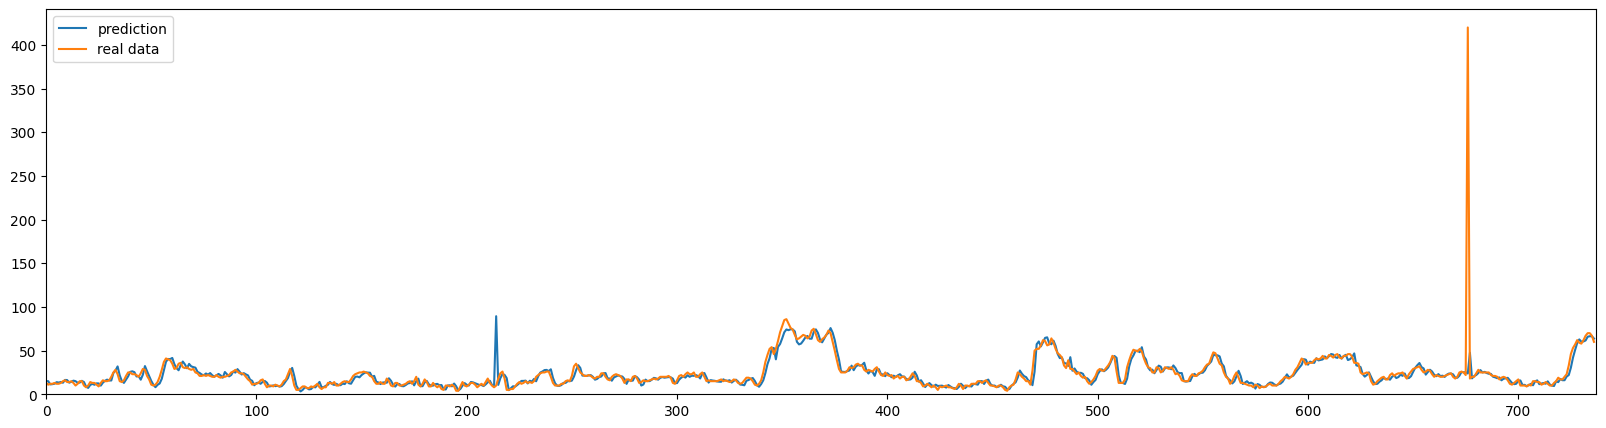

In [29]:
plt.figure(figsize=(20,5))
plt.plot(y_rf_pred,label='prediction')
plt.plot(y_test,label='real data')
plt.xlim(0,737)
plt.ylim(0,)
_ =plt.legend(loc='upper left')
print('MSE',mean_squared_error(y_test, y_rf_pred))